In [2]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import auc

In [3]:
# load dataset
dataframe = pandas.read_csv("unsw-nb15/train_binary.csv", engine='python', header=None)
dataset = dataframe.values
print(len(dataset))
X = dataset[:,0:39].astype(float)
Y = dataset[:,39].astype(int)
dataframe_test = pandas.read_csv("unsw-nb15/test_binary1.csv", engine='python', header=None)
dataset_test = dataframe.values
print(len(dataset_test))
X_test = dataset_test[:,0:39].astype(float)
Y_test = dataset_test[:,39].astype(int)
dataset_test[0]

1836
1836


array([8.000e-06, 2.000e+00, 0.000e+00, 1.762e+03, 0.000e+00, 1.250e+05,
       2.540e+02, 0.000e+00, 8.810e+08, 0.000e+00, 0.000e+00, 0.000e+00,
       8.000e-03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.810e+02,
       0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00])

In [4]:
# We didn't do encoding here, because there were just two labels
# and I did it in excel manually

# encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
#dummy_y = np_utils.to_categorical(encoded_Y)
#dummy_y

In [5]:
# Build the network
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(10, input_dim=39, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [6]:
# evaluate model with standardized dataset
# kfold approach
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 89.55% (7.75%)


In [7]:
# evaluate baseline model with standardized dataset
# with standard scaling, meaning all features were normalized to go from 0 to 1
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=8, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Standardized: 95.37% (1.41%)


In [8]:
# Fit the training data to the model
estimator.fit(X, Y, epochs=100, batch_size=8, verbose=0)


In [24]:
# test data
y_pred_keras = (estimator.predict(X_test) > 0.5).astype("int32").ravel()
probas_ = estimator.predict_proba(X_test)
print(probas_)
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, probas_[:, 1])
counter = 0
counter_acc = 0
counter_miss = 0
print(y_pred_keras[0])
for i in range(len(y_pred_keras)):
    if (y_pred_keras[i] == 1 & Y_test[i] == 0):
        counter += 1
    if (y_pred_keras[i] == 0 & Y_test[i] == 1):
        counter_miss += 1
    if (y_pred_keras[i] == 0 & Y_test[i] == 0):
        counter_acc += 1
    if (y_pred_keras[i] == 1 & Y_test[i] == 1):
        counter_acc += 1

    
print("False Positive Rate: " + str(counter/len(y_pred_keras)))
print("Miss Rate: " + str(counter_miss/len(y_pred_keras)))
print("Accuracy: " + str(counter_acc/len(y_pred_keras)))

/Users/mirzacutuk/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
1
False Positive Rate: 0.06100217864923747
Miss Rate: 0.0
Accuracy: 0.9291938997821351


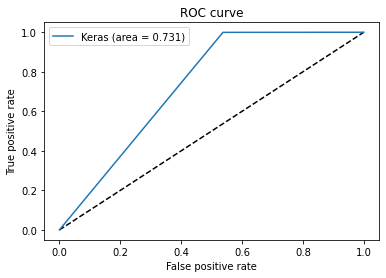

In [25]:
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()